In [1]:
from utils import *
from subvolt_kernel import diff_l2_w
from gain_task_subvolt_kernel import subvolt_fit
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

## Get example cell
* fish 1
* cell 6

In [2]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False

p_swim = l_swim+r_swim

ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]

sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)

trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

## Get x, y data and fit
* y : neural dynamics at time t
* x : spike history, swim history, visual history

In [17]:
spike_pad = 2
swim_pad = 30
visu_pad = 60
behavior_dat = [spk_list, p_swim, visu]
pad_list = [spike_pad, swim_pad, visu_pad]
w_list, ev_list, comp = subvolt_fit(sub_list, behavior_dat, pad_list, trial_valid_fit, t_pre=t_pre, reg=3)

In [20]:
w0, w, w_ = w_list
ev_model_, ev_model, ev_spike, ev_swim, ev_visual = ev_list

## Explained variance

In [21]:
print(f'EV for model {ev_model}')
print(f'EV for spike {ev_spike}')
print(f'EV for swim {ev_swim}')
print(f'EV for visual {ev_visual}')

EV for model 0.17495936336908635
EV for spike -0.0010646979445037008
EV for swim 0.13409457158908666
EV for visual 0.019502035210656632


## Kernel

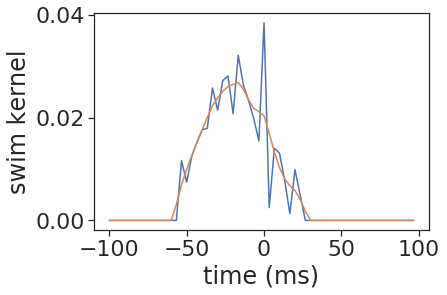

In [22]:
plt.plot(np.arange(-swim_pad,swim_pad)/300*1000, w0[spike_pad:(spike_pad+swim_pad*2)])
plt.plot(np.arange(-swim_pad,swim_pad)/300*1000, w[spike_pad:(spike_pad+swim_pad*2)])
plt.ylabel('swim kernel')
plt.xlabel('time (ms)')
plt.show()

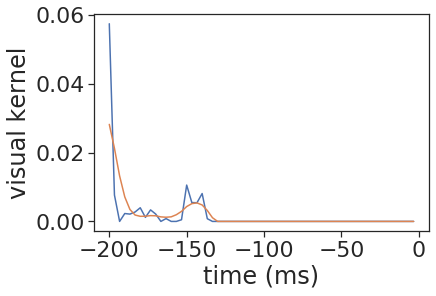

In [23]:
plt.plot(np.arange(-visu_pad,0)/300*1000, w0[(spike_pad+swim_pad*2):])
plt.plot(np.arange(-visu_pad,0)/300*1000, w[(spike_pad+swim_pad*2):])
plt.ylabel('visual kernel')
plt.xlabel('time (ms)')
plt.show()